In [1]:
import tensorflow as tf
import numpy as np
import math
na = np.newaxis
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec

# import helper functions from utils.py:
from utils import build_2d_grid, train_parameters, evaluation, tf_tril_indices, load_lookup_table, table_lookup_op_parallel, get_scp_samples, build_graph, build_eval_graph

# colormap
cmap = plt.get_cmap('plasma')

# Planning:
- get test examples to run, handle ind point limitations
- get real world dataset example to run

### BUGS:

- nans occur for too many ind points (in exp gradient)
- m and S values go to infinity if inducing_point_res >= 9

(solved?)

- implemented logdet for kl div, added stabilizer


### TODOS:
- clean code into functions
- Check T region definition (currently limits of inducing points)
- Add inducing point location optimization

- calculate and print lower bound for testset
- improve 2d sampling function
- optimize Lookup Table resolution (Max)

# 2d example

In [2]:
from scipy.stats import multivariate_normal

def double_blob_10_10(x):
    blob_1 = multivariate_normal.pdf(x, mean = [3, 3], cov=[[1, 0], [0, 1]])
    blob_2 = multivariate_normal.pdf(x, mean = [7, 7], cov=[[1, 0], [0, 1]])
    return (blob_1 + blob_2) * 10

def double_blob(x_in, Tlims):
    x = np.zeros(x_in.shape)
    x1frac = 10. / (Tlims[0,1] - Tlims[0,0])
    x2frac = 10. / (Tlims[1,1] - Tlims[1,0])
    x[:,0] = x_in[:,0] * x1frac
    x[:,1] = x_in[:,1] * x2frac
    return double_blob_10_10(x) * (x1frac * x2frac) * 10

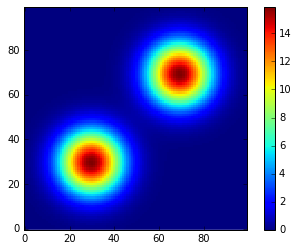

In [3]:
res = 100
Tlims = np.array([[0., 10.], [0., 10.]])

X = build_2d_grid(Tlims, res)
vals = double_blob(X, Tlims).reshape(res,res)

plt.imshow(vals, interpolation='none', origin='lower')
plt.colorbar()
plt.show()

In [4]:
upper_bound = np.ceil(np.max(vals))
samples, _, _, _, _, _ = get_scp_samples(lambda x: double_blob(x, Tlims), Tlims, upper_bound, 1)

Input dimension is : 2
Volume is: 100.0


Number of samples: 191


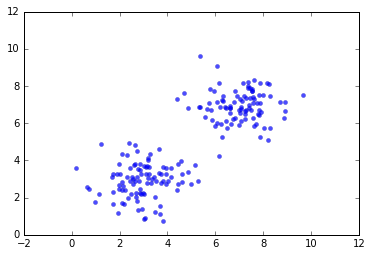

In [5]:
print('Number of samples: {}'.format(samples.shape[0]))

# sampled data:
plt.scatter(samples[:,0], samples[:,1], linewidth=0.1, alpha=.7)
plt.show()

# Variational Approximation

#### Evaluation with learned alphas and increasing number of inducing points

In [6]:
## ######## ##
# PARAMETERS #
## ######## ##

tf.logging.set_verbosity(tf.logging.DEBUG)
check_numerics = True
init_debug     = False

# general options
train_hyperparameters    = True
optimize_inducing_points = False
ind_point_num            = 6

stabilizer_value     = 1e-5
kzz_stabilizer_value = 1e-7

# gradient descent options
max_iterations = 2000
chk_iterations = 2001
learning_rate  = 0.0001

# initialization:
lvech_init_stddev = 1. # 0.001
m_init_val        = 1.

alphas_init = [1.,  1.]
gamma_init  = 1.

# tensorboard options:
logdir = 'logs/2d_blob_dem'

# build_evaluation_grid
eval_res = 100
eval_grid = build_2d_grid(Tlims, eval_res)
        
m_opt, S_opt, Kzz_inv_opt, alphas_opt, Z_opt,gamma_opt = train_parameters(samples, ind_point_num, Tlims, 
                                                                          optimize_inducing_points=optimize_inducing_points, 
                                                                          train_hyperparameters=train_hyperparameters,
                                                                          learning_rate=learning_rate,
                                                                          max_iterations=max_iterations,
                                                                          chk_iters = chk_iterations,
                                                                          log_dir=logdir,
                                                                          alphas_init=alphas_init,
                                                                          gamma_init=gamma_init,
                                                                          lvech_init_stddev=lvech_init_stddev,
                                                                          m_init_val=m_init_val,
                                                                          check_numerics=check_numerics,
                                                                          stabilizer_value=stabilizer_value,
                                                                          kzz_stabilizer_value=kzz_stabilizer_value,
                                                                          enable_initialization_debugging=init_debug
                                                                         )
lam_vals, lam_var = evaluation(m_opt,S_opt,Kzz_inv_opt,alphas_opt,gamma_opt,Z_opt, eval_grid)

Begin training
Fixed inducing points on a grid
Z.shape: (36, 2)


ind point number:  6
alphas:  [ 0.01591596  0.01712023]
gamma:  2.72757930169


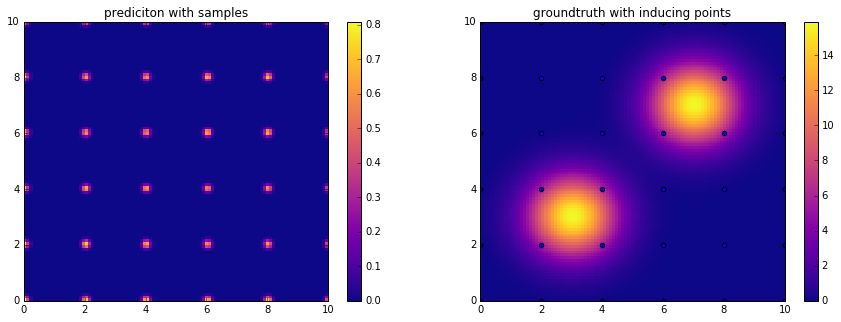

In [7]:
#plots
fig = plt.figure(figsize=(15, 5)) 
max_value = np.max([np.max(vals), np.max(lam_vals)])
norm = mpl.colors.Normalize(vmin=0, vmax=max_value)

print("ind point number: ",ind_point_num)
print("alphas: ",alphas_opt)
print("gamma: ",gamma_opt)

xx, yy = np.meshgrid(np.linspace(Tlims[0,0], Tlims[0,1], eval_res), np.linspace(Tlims[1,0], Tlims[1,1], eval_res))

ax0 = plt.subplot(1,2,1)
im = ax0.pcolormesh(xx, yy, lam_vals.reshape(eval_res,eval_res), cmap=cmap)#, norm=norm)
fig.colorbar(im, ax=ax0)
ax0.set_title('prediciton with samples')
# ax0.scatter(samples[:,0], samples[:,1])
plt.xlim(Tlims[0,0], Tlims[0,1])
plt.ylim(Tlims[1,0], Tlims[1,1])

ax1 = plt.subplot(1,2, 2)
im1 = ax1.pcolormesh(xx, yy, vals, cmap=cmap,norm=norm)
fig.colorbar(im1, ax=ax1)
ax1.set_title('groundtruth with inducing points')
ax1.scatter(Z_opt[:, 0], Z_opt[:,1])
plt.xlim(Tlims[0,0], Tlims[0,1])
plt.ylim(Tlims[1,0], Tlims[1,1])
#plt.savefig('results/' + run_prefix + '_result.png', dpi=300)
plt.show()